# A sampler study

In this notebook, we perform a short study of how various samplers implemented in pyPESTO perform.

## The pipeline

First, we show a typical workflow, fully integrating the samplers with a [PEtab](https://github.com/petab-dev/petab) problem, using a toy example of a conversion reaction.

In [1]:
import pypesto
import petab

# import to petab
petab_problem = petab.Problem.from_yaml(
    "conversion_reaction/conversion_reaction.yaml")
# import to pypesto
importer = pypesto.PetabImporter(petab_problem)
# create problem
problem = importer.create_problem()

Commonly, as a first step, optimization is performed, in order to find good parameter point estimates.

In [2]:
result = pypesto.minimize(problem, n_starts=10)

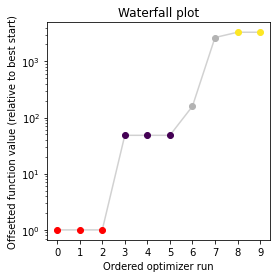

In [3]:
pypesto.visualize.waterfall(result, size=(4,4))

Next, we perform sampling. Here, we employ a `pypesto.sample.AdaptiveParallelTemperingSampler` sampler, which runs Markov Chain Monte Carlo (MCMC) chains on different temperatures. For each chain, we employ a `pypesto.sample.AdaptiveMetropolisSampler`. For more on the samplers see below or the API documentation.

In [4]:
sampler = pypesto.AdaptiveParallelTemperingSampler(
    internal_sampler=pypesto.AdaptiveMetropolisSampler(),
    n_chains=3)

For the actual sampling, we call the `pypesto.sample` function. By passing the result object to the function, the previously found global optimum is used as starting point for the MCMC sampling.

In [5]:
result = pypesto.sample(problem, n_samples=10000, sampler=sampler, result=result)

When the sampling is finished, we can analyse our results. pyPESTO provides functions to analyse both the sampling process as well as the obtained sampling result. Visualizing the traces e.g. allows to detect burn-in phases, or fine-tune hyperparameters. First, the parameter trajectories  can be visualized:

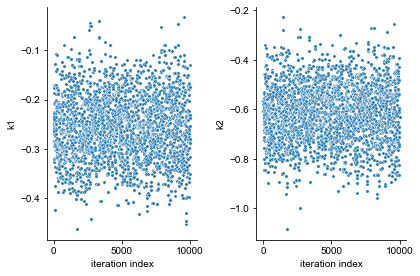

In [6]:
pypesto.visualize.sampling_parameters_trace(result, use_problem_bounds=False)

Next, also the log posterior trace can be visualized:

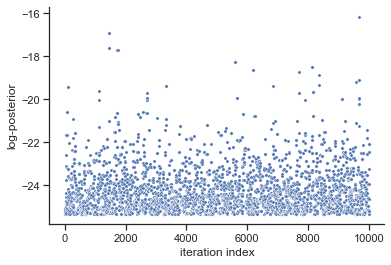

In [7]:
pypesto.visualize.sampling_fval_trace(result)

To visualize the result, there are various options. The scatter plot shows histograms of 1-dim parameter marginals and scatter plots of 2-dimensional parameter combinations:

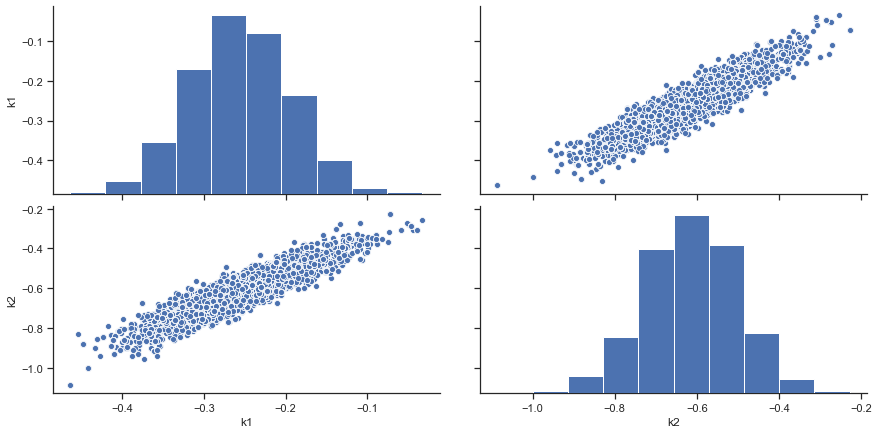

In [8]:
pypesto.visualize.sampling_scatter(result, size=[13,6])

`sampling_1d_marginals` allows to plot e.g. kernel density estimates or histograms (internally using [seaborn](https://seaborn.pydata.org/)):

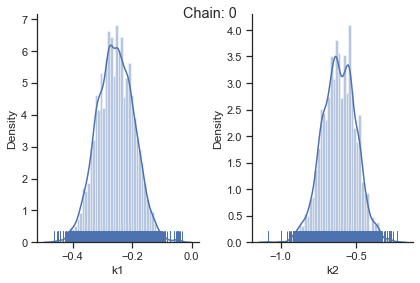

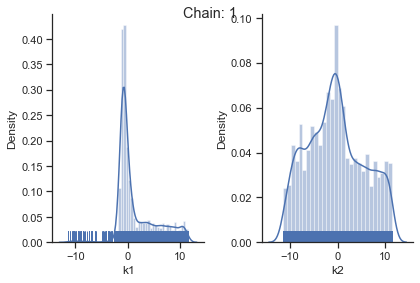

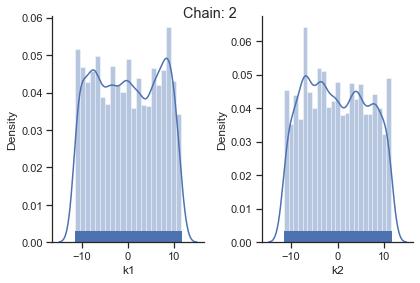

In [9]:
for i_chain in range(len(result.sample_result.betas)):
    pypesto.visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}")

That's it for the moment on using the sampling pipeline.

## 1-dim test problem

To compare and test the various implemented samplers, we first study a 1-dimensional test problem of a gaussian mixture density, together with a flat prior.

In [10]:
import numpy as np
from scipy.stats import multivariate_normal
import seaborn as sns
import pypesto

def density(x):
    return 0.3*multivariate_normal.pdf(x, mean=-1.5, cov=0.1) + \
        0.7*multivariate_normal.pdf(x, mean=2.5, cov=0.2)

def p(x):
    return - np.log(density(x))

objective = pypesto.Objective(fun=p)
problem = pypesto.Problem(
    objective=objective, lb=np.array(-10), ub=np.array(10), x_names=['x'])

The likelihood has two separate modes:

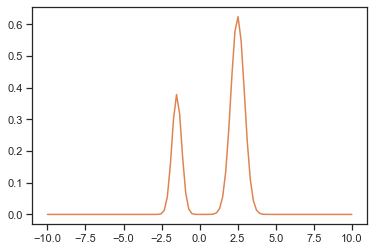

In [11]:
xs = np.linspace(-10, 10, 100)
ys = [density(x) for x in xs]

sns.lineplot(xs, ys, color='C1')

### Metropolis sampler

For this problem, let us try out the simplest sampler, the `pypesto.sample.MetropolisSampler`.

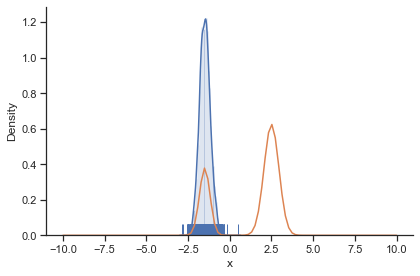

In [12]:
sampler = pypesto.MetropolisSampler({'std': 0.5})
result = pypesto.sample(problem, 1e4, sampler, x0=np.array([0.5]))

ax = pypesto.visualize.sampling_1d_marginals(result)
ax[0][0].plot(xs, ys)

The obtained posterior does not accurately represent the distribution, often only capturing one mode. This is because it is hard for the Markov chain to jump between the distribution's two modes. This can be fixed by choosing a higher proposal variation `std`:

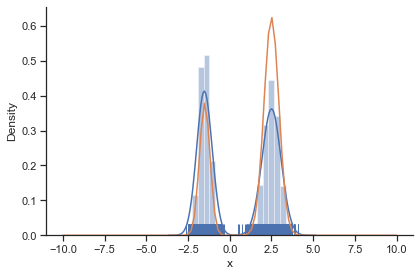

In [13]:
sampler = pypesto.MetropolisSampler({'std': 1})
result = pypesto.sample(problem, 1e4, sampler, x0=np.array([0.5]))

ax = pypesto.visualize.sampling_1d_marginals(result)
ax[0][0].plot(xs, ys)

In general, MCMC have difficulties exploring multimodel landscapes. One way to overcome this is to used parallel tempering. There, various chains are run, lifting the densities to different temperatures. At high temperatures, proposed steps are more likely to get accepted and thus jumps between modes more likely.



### Parallel tempering sampler

In pyPESTO, the most basic parallel tempering algorithm is the `pypesto.sample.ParallelTemperingSampler`. It takes an `internal_sampler` parameter, to specify what sampler to use for performing sampling the different chains. Further, we can directly specify what inverse temperatures `betas` to use. When not specifying the `betas` explicitly but just the number of chains `n_chains`, an established near-exponential decay scheme is used.

In [14]:
sampler = pypesto.ParallelTemperingSampler(
    internal_sampler=pypesto.MetropolisSampler(),
    betas=[1, 1e-1, 1e-2])
result = pypesto.sample(problem, 1e4, sampler, x0=np.array([0.5]))

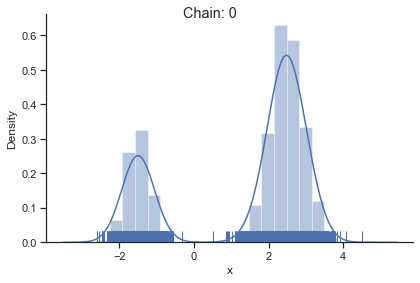

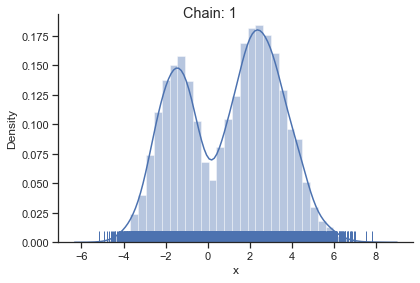

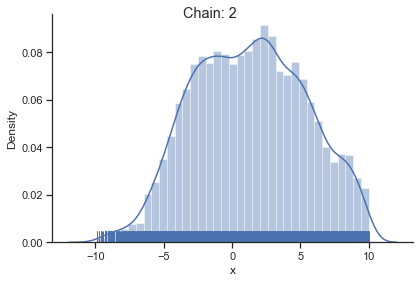

In [15]:
for i_chain in range(len(result.sample_result.betas)):
    pypesto.visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}")

Of interest is here finally the first chain at index `i_chain=0`, which approximates the posterior well.

### Adaptive Metropolis sampler

The problem of having to specify the proposal step variation manually can be overcome by using the `pypesto.sample.AdaptiveMetropolisSampler`, which iteratively adjusts the proposal steps to the function landscape.

In [16]:
sampler = pypesto.AdaptiveMetropolisSampler()
result = pypesto.sample(problem, 1e4, sampler, x0=np.array([0.5]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cbc3c6290>]],
      dtype=object)

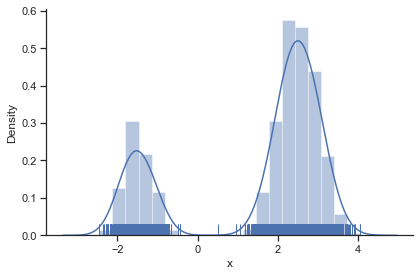

In [17]:
pypesto.visualize.sampling_1d_marginals(result)

### Adaptive parallel tempering sampler

The `pypesto.sample.AdaptiveParallelTemperingSampler` iteratively adjusts the temperatures to obtain good swapping rates between chains.

In [18]:
sampler = pypesto.AdaptiveParallelTemperingSampler(
    internal_sampler=pypesto.AdaptiveMetropolisSampler(), n_chains=3)
result = pypesto.sample(problem, 1e4, sampler, x0=np.array([0.5]))

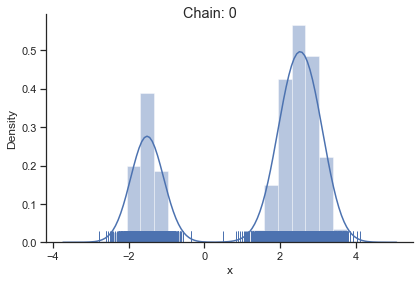

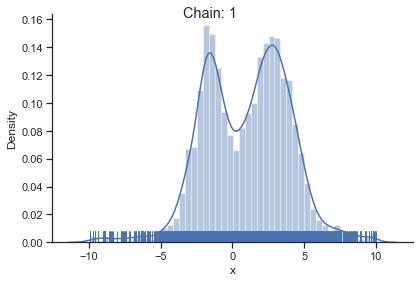

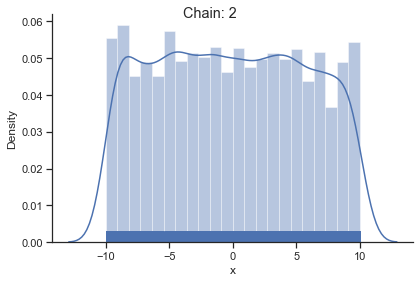

In [19]:
for i_chain in range(len(result.sample_result.betas)):
    pypesto.visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}")

In [20]:
result.sample_result.betas

array([1.00000000e+00, 8.02757714e-02, 2.00000000e-05])

## 2-dim test problem: Rosenbrock banana

The adaptive parallel tempering sampler with chains running adaptive Metropolis samplers is also possible to sample from more challenging posterior distributions. To illustrates this shortly, we use the Rosenbrock function.

In [21]:
import scipy.optimize as so
import pypesto

# first type of objective
objective = pypesto.Objective(fun=so.rosen)

dim_full = 4
lb = -5 * np.ones((dim_full, 1))
ub = 5 * np.ones((dim_full, 1))

problem = pypesto.Problem(objective=objective, lb=lb, ub=ub)

In [23]:
sampler = pypesto.AdaptiveParallelTemperingSampler(
    internal_sampler=pypesto.AdaptiveMetropolisSampler(), n_chains=10)
result = pypesto.sample(problem, 1e4, sampler, x0=np.zeros(dim_full))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cbb524390>,
      dtype=object)

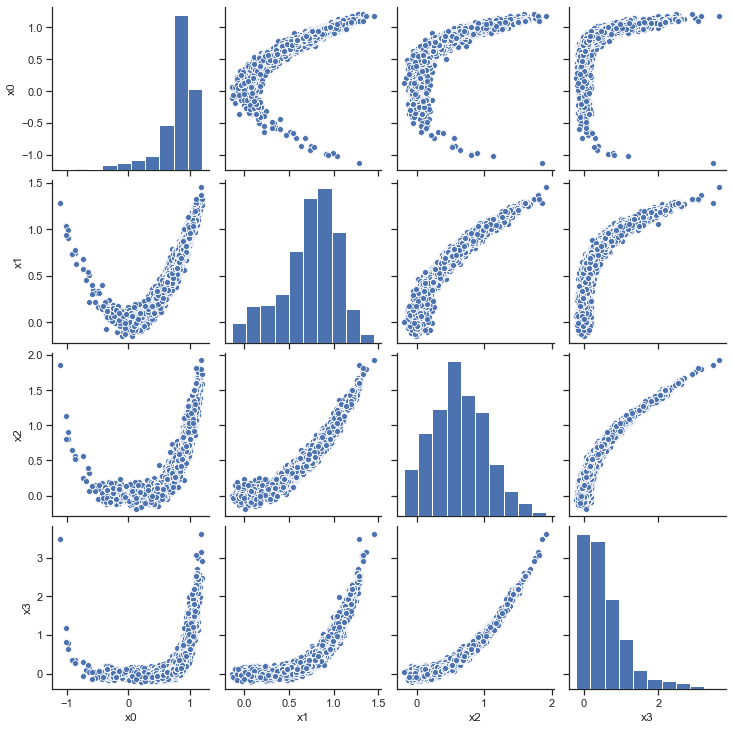

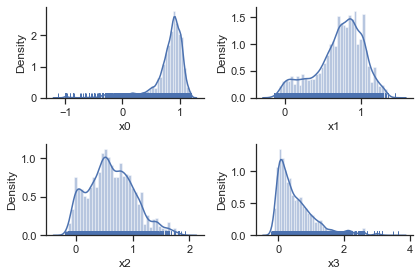

In [24]:
pypesto.visualize.sampling_scatter(result)
pypesto.visualize.sampling_1d_marginals(result)